In [1]:
import os
import pywt
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import ipywidgets as widgets
import time
import cv2
from scipy.io import savemat
%matplotlib ipympl

from harvesters.core import Harvester

from PIL import Image

In [2]:
h = Harvester()

# if you have installed diaphus via the C4Utility Installer, the DIAPHUS_GENTL64_FILE
# environment variable below is automatically set
# Otherwise set it by uncommenting and completing the line below
# %env DIAPHUS_GENTL64_FILE /<path>/<to>/diaphus.cti
cti_file = os.getenv("DIAPHUS_GENTL64_FILE")

h.add_file(cti_file)
h.update()

In [3]:
label = f"{len(h.device_info_list)} devices detected on the network"
options = []
for i, dev in enumerate(h.device_info_list):
    options.append(f"{dev.id_}  (SN: \"{dev.serial_number}\")")

# just the widget below
w = widgets.RadioButtons(options=options, description=label, disabled=False)
display(w)

C:\ProgramData\anaconda3\envs\helicam\lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


RadioButtons(description='1 devices detected on the network', options=('DiaphusTL_DEV_192.168.2.71  (SN: "1450…

In [4]:
camera = h.create(w.index)

In [5]:
# configure triggering
camera.remote_device.node_map.TriggerSelector.value = 'RecordingStart'
camera.remote_device.node_map.TriggerMode.value = 'Off'
print(
    f"RecordingStart default TriggerSource in DeviceMode=LockinCam: {camera.remote_device.node_map.TriggerSource.value}"
)
camera.remote_device.node_map.TriggerSelector.value = 'FrameStart'
camera.remote_device.node_map.TriggerMode.value = 'On'
print(
    f"FrameStart default TriggerSource in DeviceMode=LockinCam: {camera.remote_device.node_map.TriggerSource.value}"
)
camera.remote_device.node_map.TriggerSource.value = 'Software'

RecordingStart default TriggerSource in DeviceMode=LockinCam: Stage
FrameStart default TriggerSource in DeviceMode=LockinCam: Software


In [6]:
def lia_config(sensitivity=0.5,
               n_periods=20,
               internal_ref=True,
               ref_frequency=1000,
               frames = 200):
    camera.remote_device.node_map.DeviceOperationMode.value = 'LockInCam'
    camera.remote_device.node_map.LockInSensitivity.value = sensitivity
    camera.remote_device.node_map.LockInTargetTimeConstantNPeriods.value = n_periods
    camera.remote_device.node_map.LockInCoupling.value = 'DC'
    camera.remote_device.node_map.AcquisitionBurstFrameCount.value = frames
    # configure the RTIO outputs to the recording active signal and the reference demodulation frequency
    camera.remote_device.node_map.LineSelector.value = "RTIO2"
    camera.remote_device.node_map.LineSource.value = "LockInReference"
    camera.remote_device.node_map.LineSelector.value = "RTIO3"
    camera.remote_device.node_map.LineSource.value = "RecordingActive"

    if internal_ref:
        camera.remote_device.node_map.LockInReferenceSourceType.value = 'Internal'
        camera.remote_device.node_map.LockInTargetReferenceFrequency.value = ref_frequency
        camera.remote_device.node_map.LockInExpectedFrequencyDeviation.value = 1
    else:
        camera.remote_device.node_map.LockInReferenceSourceType.value = 'External'
        camera.remote_device.node_map.LockInReferenceFrequencyScaler.value = 'Off'
        camera.remote_device.node_map.LockInReferenceSourceSignal.value = 'FI3'
        camera.remote_device.node_map.LockInExpectedFrequencyDeviation.value = 1

lia_config()  # initialize with the default settings

In [7]:
camera.remote_device.node_map.SignalGeneratorFrequency.value = 1000
camera.remote_device.node_map.SignalGeneratorAmplitude.value = 100.0
camera.remote_device.node_map.SignalGeneratorOffset.value = 50.0
camera.remote_device.node_map.SignalGeneratorMode.value = "On"
camera.remote_device.node_map.LightControllerSelector.value = "LightController0"
camera.remote_device.node_map.LightControllerSource.value = "SignalGenerator"

In [8]:
camera.remote_device.node_map.Scan3dExtractionMethod.value = "rawIQ"

In [9]:

def acquire(auto_stop=True):
    camera.start()
    camera.remote_device.node_map.TriggerSoftware.execute()
    
    with camera.fetch(timeout=40) as buffer:
        n_frames = len(buffer.payload.components) // 2
        height = buffer.payload.components[0].height
        width = buffer.payload.components[0].width

        n_frames = len(buffer.payload.components) // 2
        out_shape = (n_frames, height, width)

        def transform_raw(img):
            return (img % 2**15) / 2**2

        # harvesters returns data as 1D np arrays
        I_1d = np.array([
            transform_raw(img.data.astype(float))
            for img in buffer.payload.components[:n_frames]
        ])
        Q_1d = np.array([
            transform_raw(img.data.astype(float))
            for img in buffer.payload.components[n_frames:2 * n_frames]
        ])
    if auto_stop:
        camera.stop()
    return (I_1d, Q_1d, height, width)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


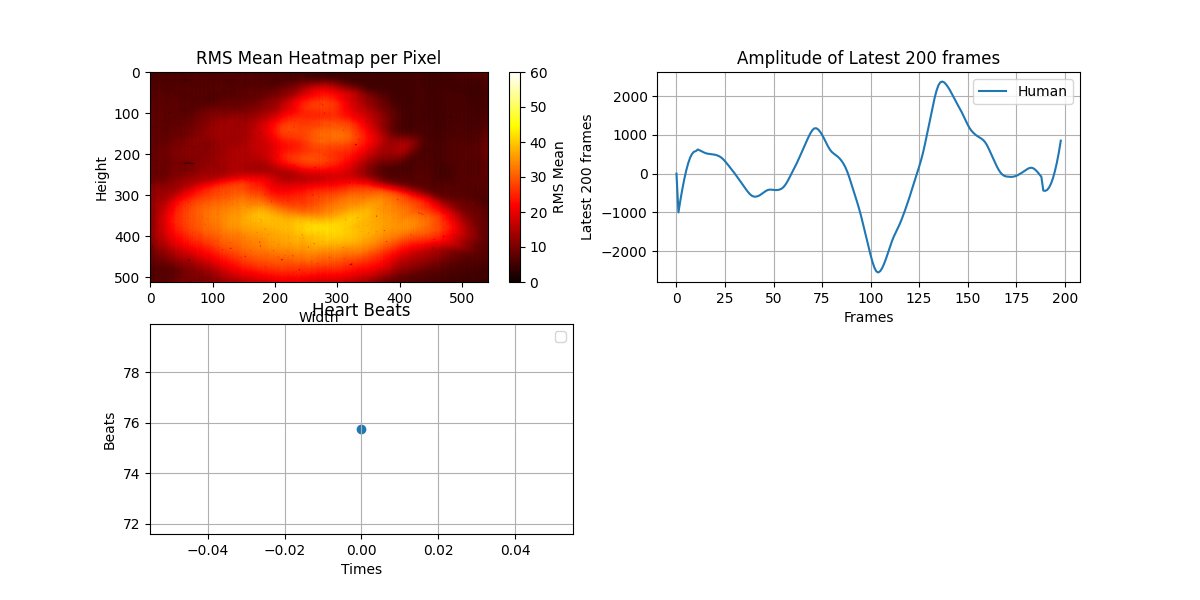

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


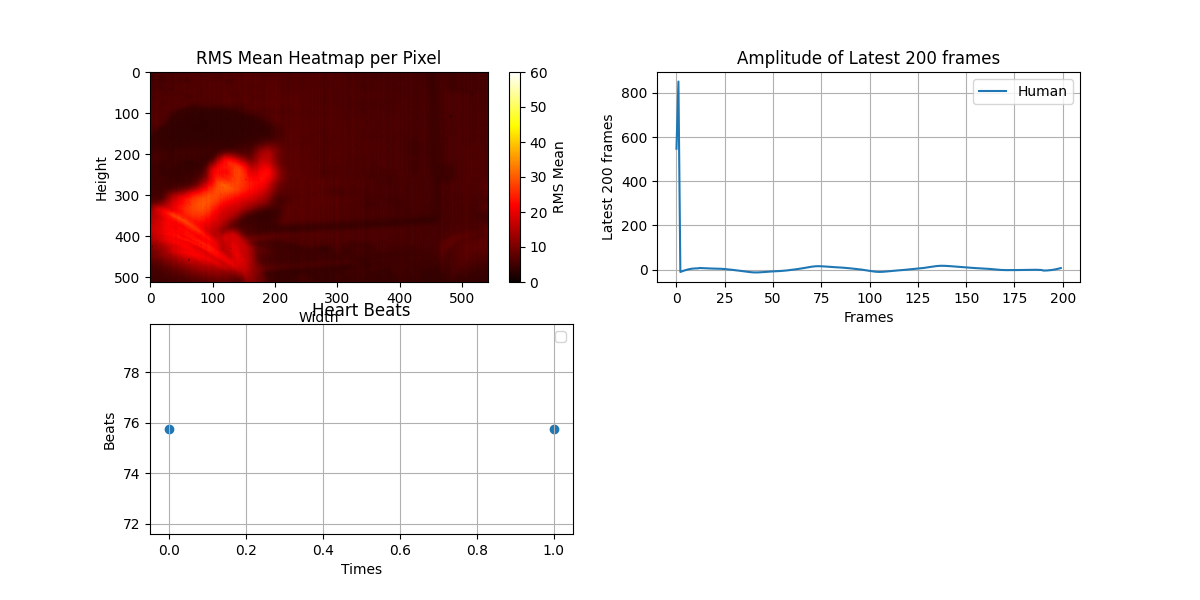

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


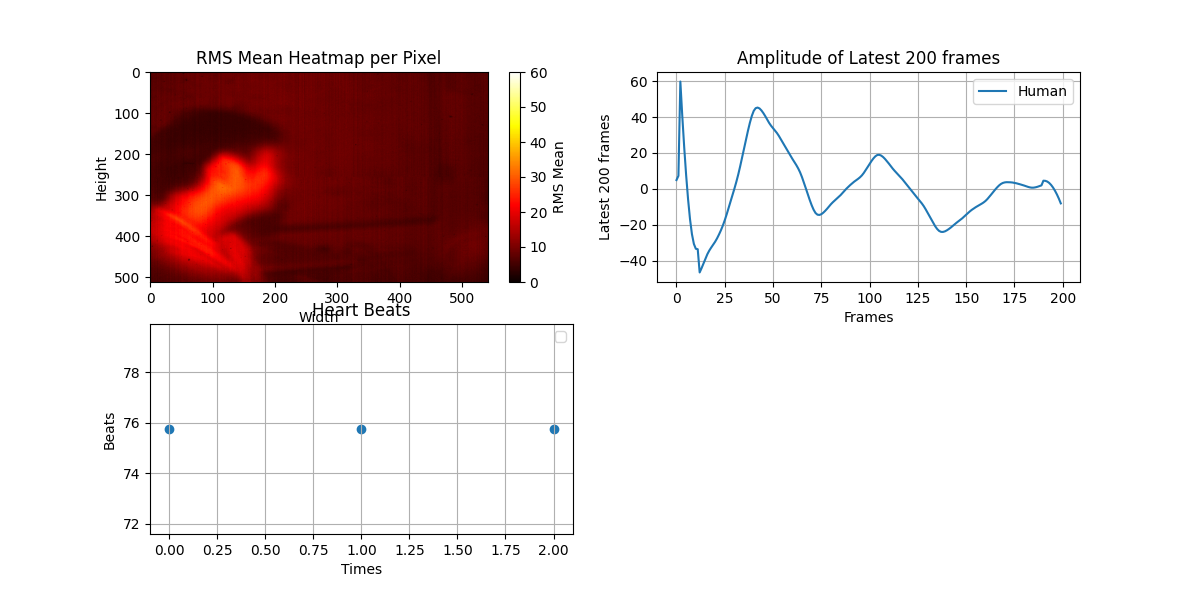

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


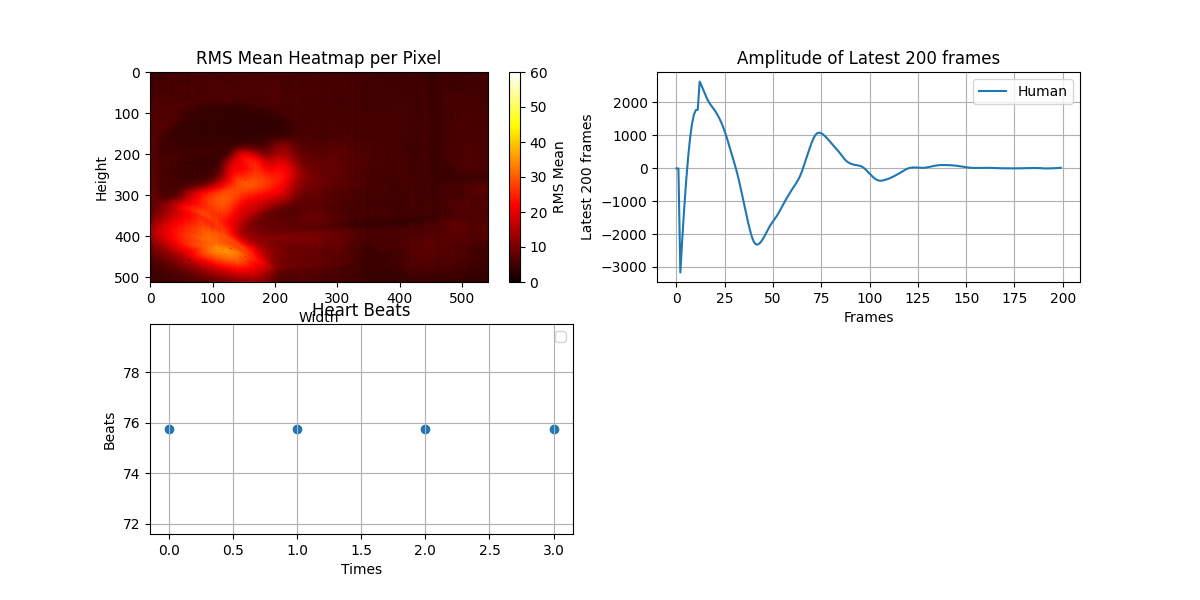

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


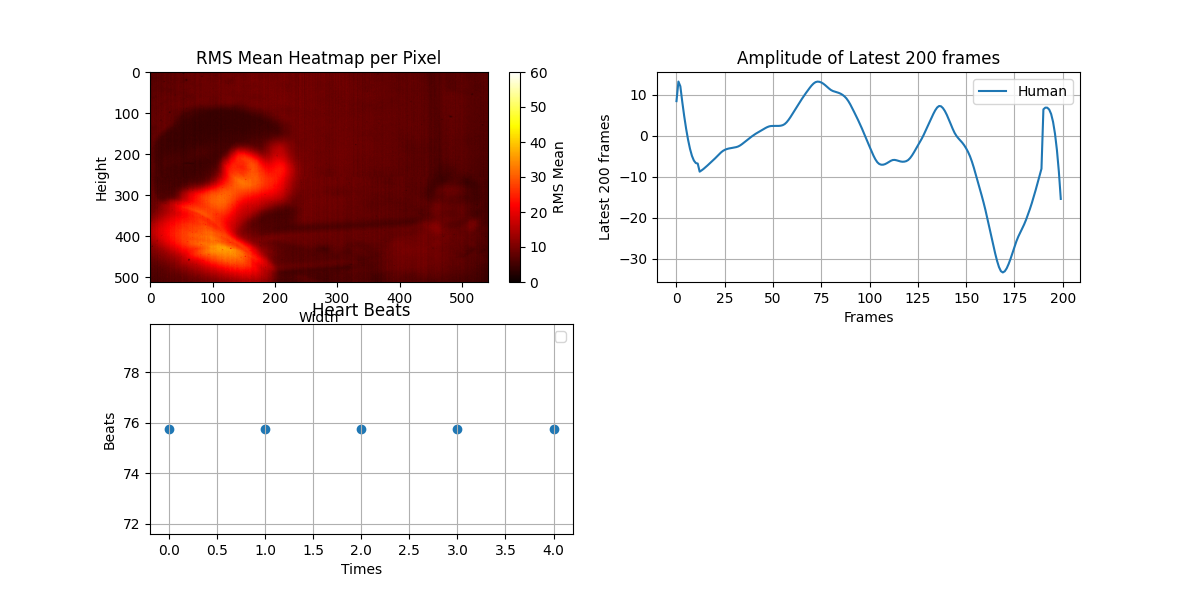

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


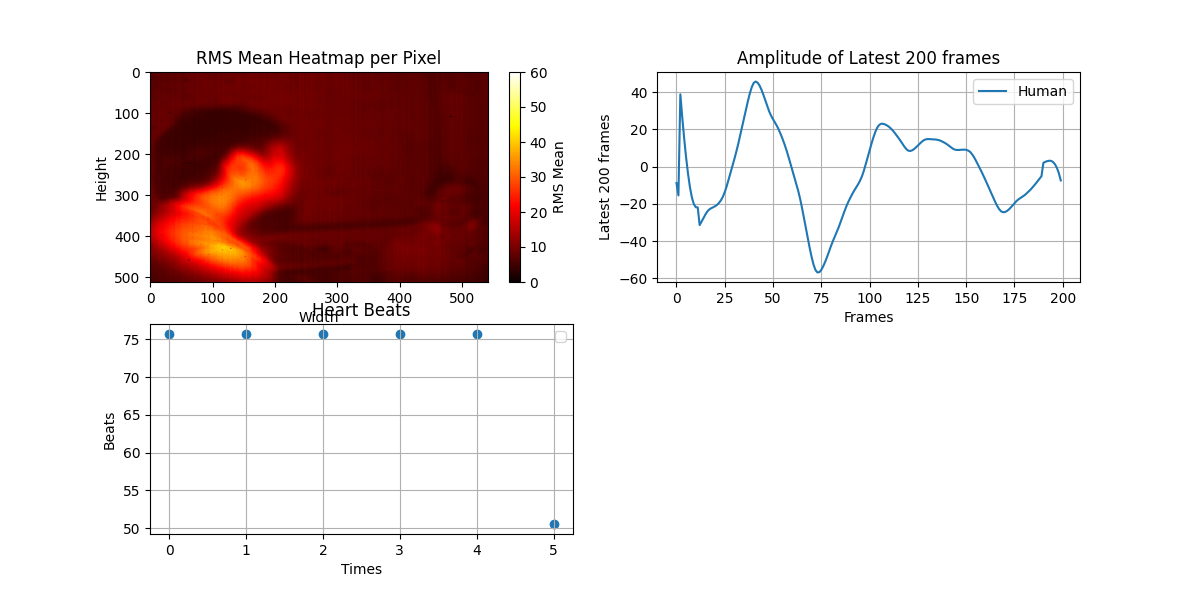

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


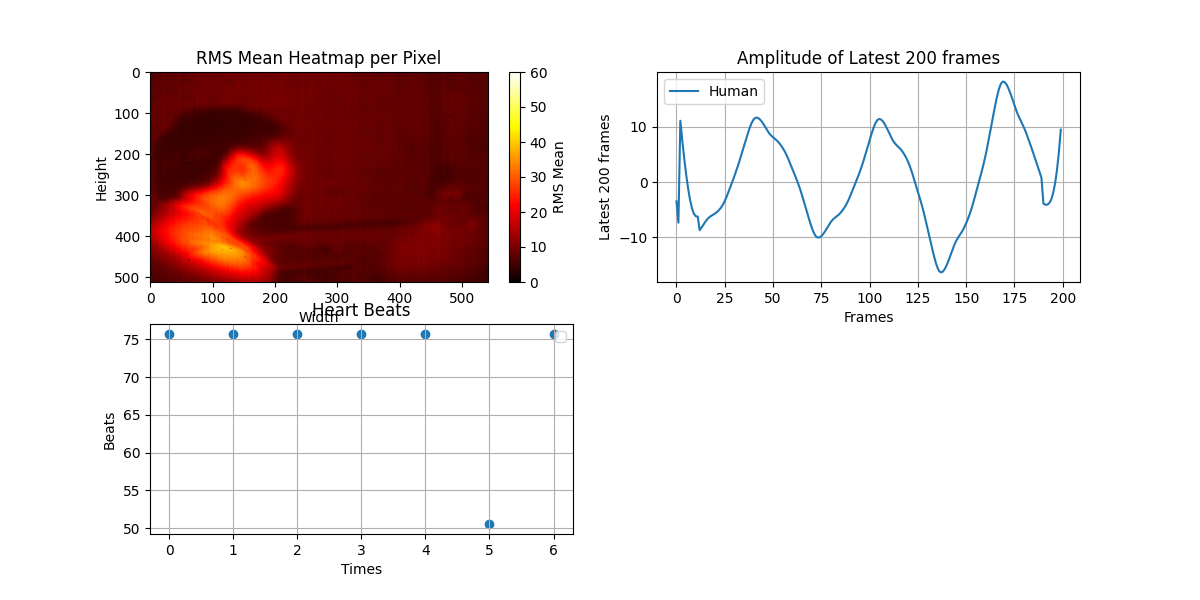

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


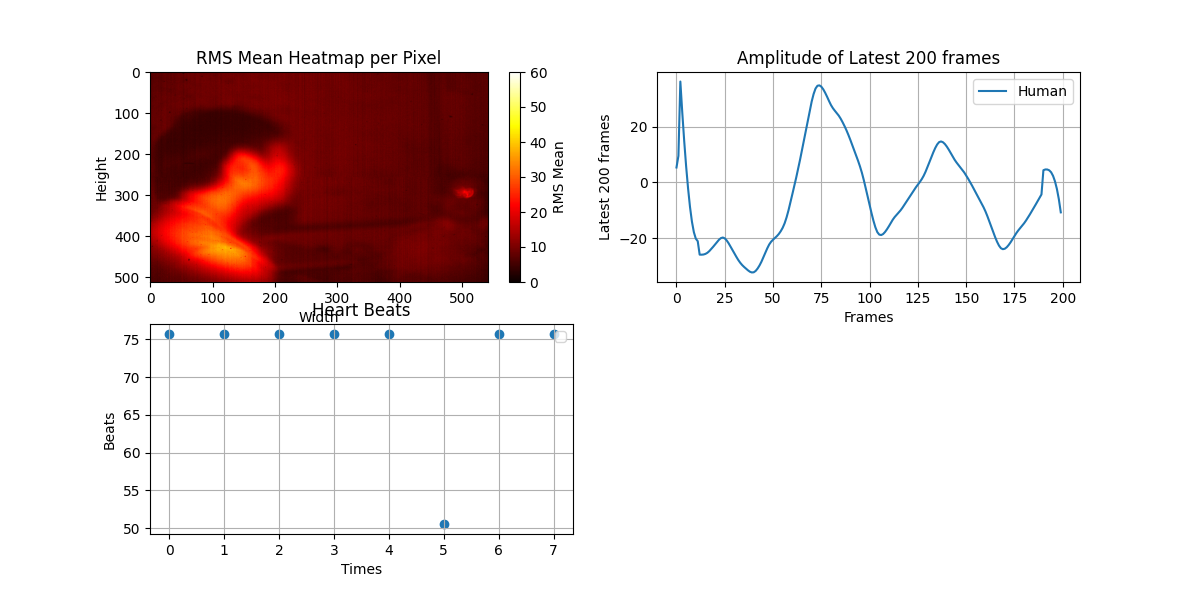

KeyboardInterrupt: 

In [26]:

num_plots = 0
realdata = np.zeros(1)
realdata1 = np.zeros(1)
frame_time = 2
time_data = np.array([])
Beats = []


frame_width = 640
frame_height = 480
out = cv2.VideoWriter('output.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))

frame_list = []
Amplitude_list = []
Beats_list = []

# 循环获取图像并绘制
while num_plots < 15:
    # 获取图像数据
    ret = acquire()
    I_1d = ret[0]
    Q_1d = ret[1]
    height = ret[2]
    width = ret[3]

    # 处理图像数据
    n_frames = I_1d.shape[0]
    I = I_1d.reshape((n_frames, height, width))[2:, :, :]
    Q = Q_1d.reshape((n_frames, height, width))[2:, :, :]

    I_mean = np.loadtxt('I_mean.txt')
    Q_mean = np.loadtxt('Q_mean.txt')

    I = I - I_mean
    Q = Q - Q_mean

    rms = np.sqrt(I**2 + Q**2)

    rms_mean_per_pixel = np.mean(rms, axis=0)
    
    rms_mean_per_pixel_rotated = np.rot90(rms_mean_per_pixel)
    
    total_per_frame = np.sum(rms[:, 200:250, 150:200], axis=(1, 2))  # 沿着宽度和高度方向求和
    
    wavelet = 'sym8'
    kept_levels = 5
    window_length = 20
    
    # Create an example data
    data = total_per_frame
    
    # Perform wavelet transform
    coeffs = pywt.wavedec(data, wavelet, level=kept_levels)
    
    # Remove high-frequency signals
    for i in range(1, len(coeffs)):
        coeffs[i] = np.zeros_like(coeffs[i])
    
    # Reconstruct the signal
    data_filt = pywt.waverec(coeffs, wavelet)

    # Baseline removal
    baseline_removed = data_filt - savgol_filter(data_filt, window_length, 1)
 
    realdata = np.concatenate((realdata, baseline_removed))

    fft_data = np.fft.fft(baseline_removed)
    
    # Compute frequencies
    sampling_rate = 1 / 0.02  # Assuming a sampling interval of 0.02 seconds (50 Hz sampling rate)
    frequencies = np.fft.fftfreq(len(baseline_removed), d=0.02)


    freq_range_start = 0.5  # Hz
    freq_range_end = 1.5    # Hz
    
    # Find the indices corresponding to the specified frequency range
    indices = np.where((frequencies >= freq_range_start) & (frequencies <= freq_range_end))[0]
    
    # Extract FFT values within the specified frequency range
    fft_values_in_range = np.abs(fft_data)[indices]
    
    # Find the index of the maximum value within the specified frequency range
    max_index = np.argmax(fft_values_in_range)
    
    # Retrieve the corresponding frequency
    max_frequency = frequencies[indices][max_index]
    
    # Multiply the frequency by 100
    max_frequency_times_100 = max_frequency * 100
    
    Beats.append(max_frequency_times_100)

    
    # 更新计数器
    num_plots += 1

    # 停止0.1秒，以便获取下一帧图像
    time.sleep(0.01)


In [27]:
camera.stop()

In [28]:
camera.destroy()
h.reset()